In [1]:
import os, time, math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyvi.ViTokenizer import ViTokenizer
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import pickle

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
def load_data(path):
    with open(path, 'r', encoding="latin-1") as f:
        lines = f.readlines()
    
    data = []
    label = []
    
    for line in lines:
        line = line.strip()
        splitted_line = line.split(None, 1)
        label.append(int(splitted_line[0]))
        data.append(splitted_line[1])
    
    print("Read file {} done : {} lines".format(path, len(data)))
    return data, label

In [3]:
# Define path
data_dir = "./Data"
train_file_path = os.path.join(data_dir, "train.txt")
ham_test_path = os.path.join(data_dir, "ham_test.txt")
spam_test_path = os.path.join(data_dir, "spam_test.txt")

In [4]:
# Load training data
training_data, training_label = load_data(train_file_path)

train_size = len(training_data)
num_hams = np.sum(np.array(training_label) == 1)
num_spams = np.sum(np.array(training_label) == -1)

print("Number hams  : ", num_hams)
print("Number spams : ", num_spams)
print("Train size   : ", train_size)


Read file ./Data/train.txt done : 100 lines
Number hams  :  49
Number spams :  51
Train size   :  100


In [5]:
# Load test data
ham_test_data, ham_test_label = load_data(ham_test_path)
spam_test_data, spam_test_label = load_data(spam_test_path)

num_hams_test = len(ham_test_data)
num_spams_test = len(spam_test_data)
print("Number hams test  : ", num_hams_test)
print("Number spams test : ", num_spams_test)

test_data = ham_test_data + spam_test_data
test_label = np.array(ham_test_label + spam_test_label)
test_size = len(test_data)
print("Test size : ", test_size)

Read file ./Data/ham_test.txt done : 35 lines
Read file ./Data/spam_test.txt done : 43 lines
Number hams test  :  35
Number spams test :  43
Test size :  78


In [6]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    # Transform raw text data to tf-idf
    def __init__(self):
        self.tokenize = word_tokenize
        self.tfidf = TfidfVectorizer()

    def fit(self, X, *_):
        result = [re.sub(r'[^\w\s]', '', document) for document in X]
        self.tfidf.fit(result)
        return self

    def transform(self, X, y=None, **fit_params):
        # Remove punctuation
        result = [re.sub(r'[^\w\s]', '', document) for document in X]
        result = self.tfidf.transform(result)
        return result

In [7]:
ft = FeatureTransformer()
ft.fit(training_data)
transformed_training_data = ft.transform(training_data)
transformed_test_data = ft.transform(test_data)
print("Shape of transformed traning data : ", transformed_training_data.shape)
print("Shape of transformed test data : ", transformed_test_data.shape)

Shape of transformed traning data :  (100, 612)
Shape of transformed test data :  (78, 612)


In [8]:
accuracies = {}
preds = {}
cv = 5

In [9]:
# Naive Bayes
model_name = "MNB"

# Training
param_grid = {"alpha": [0.01, 0.03, 0.1, 0.3, 1]}
mnb_clf = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=cv)
mnb_clf.fit(transformed_training_data, training_label)
print("{}: Best param : {}".format(model_name, mnb_clf.best_params_))
print("Best accuracy score : {}".format(mnb_clf.best_score_))

# Evaluate
pred_mnb = mnb_clf.predict(transformed_test_data)
acc_score_mnb = mnb_clf.best_score_

# Add result to dict
preds[model_name] = pred_mnb
accuracies[model_name] = acc_score_mnb

MNB: Best param : {'alpha': 0.1}
Best accuracy score : 0.89


In [10]:
# SVM
model_name = "SVM"

# Training
param_grid = {
    "C": [0.01, 0.03, 0.1, 0.3, 1],
    "kernel" : ["rbf", "sigmoid"],
    "gamma": np.linspace(0.1, 1, 4),
}
svm_clf = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
svm_clf.fit(transformed_training_data, training_label)
print("{}: Best param : {}".format(model_name, svm_clf.best_params_))
print("Best accuracy score : {}".format(svm_clf.best_score_))

# Evaluate
pred_svm = svm_clf.predict(transformed_test_data)
acc_score_svm = svm_clf.best_score_

# Add result to dict
preds[model_name] = pred_svm
accuracies[model_name] = acc_score_svm

SVM: Best param : {'kernel': 'rbf', 'gamma': 0.4, 'C': 1}
Best accuracy score : 0.93


In [11]:
# Random Forest
model_name = "Random Forest"

# Training
param_grid = {
    "max_features": np.linspace(0.2, 1, 5),
    "n_estimators": np.arange(50, 150, 30),
#     "min_samples_leaf": np.arange(2, 20, 5),
    "max_depth": np.arange(30, 80, 20)
}
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv)
rf_clf.fit(transformed_training_data, training_label)
print("{}: Best param : {}, Best acc score : {}".format(model_name, rf_clf.best_params_, rf_clf.best_score_))

# Evaluate
pred_rf = rf_clf.predict(transformed_test_data)
acc_score_rf = rf_clf.best_score_

# Add result to dict
preds[model_name] = pred_rf
accuracies[model_name] = acc_score_rf

Random Forest: Best param : {'max_depth': 70, 'max_features': 0.2, 'n_estimators': 110}, Best acc score : 0.92


In [12]:
# Ensemble
model_name = "Ensemble"

# Ensemble predict of all model by major voting
pred_ensemble = np.stack([pred for pred in preds.values()])
pred_ensemble = pred_ensemble.sum(axis=0)
pred_ensemble[pred_ensemble == 0] = np.random.uniform(-1,1)
pred_ensemble[pred_ensemble >= 0] = 1
pred_ensemble[pred_ensemble < 0] = -1

acc_score_ensemble = accuracy_score(test_label, pred_ensemble)

# Add result to dict
preds[model_name] = pred_ensemble
accuracies[model_name] = acc_score_ensemble

print("{}: Best acc score : {}".format(model_name, acc_score_ensemble))

Ensemble: Best acc score : 0.717948717948718


In [13]:
# Build dataframe to plot result
model_names = accuracies.keys();
accuracy_lst = [accuracies.get(model_name) for model_name in model_names]

stats = pd.DataFrame({"Accuracy" : accuracy_lst}, index=model_names)
stats.sort_values(by="Accuracy", inplace=True)

stats.head()

,Accuracy
Ensemble,0.717949
MNB,0.890000
Random Forest,0.920000
SVM,0.930000


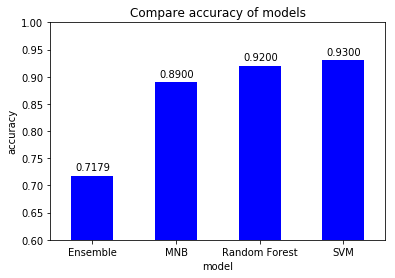

In [14]:
# Plot accuracy stats
ax = stats.plot(y="Accuracy", kind="bar", color="b")
ax.set(title="Compare accuracy of models", xlabel="model", ylabel="accuracy", ylim=[0.6,1])
ax.legend().set_visible(False)
plt.xticks(rotation=0)

x_offset = -0.2
y_offset = 0.01

# add value into plot to see clearly
for p in ax.patches:
    b = p.get_bbox()
#     print(b)
    acc_value = "{:.4f}".format(b.y0 + b.y1)
    ax.annotate(acc_value, xy=((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [17]:
# Choose best model by look at accuracy on cross-validation
best_model = rf_clf
pred_label = best_model.predict(transformed_test_data)
acc_score_best_model = accuracy_score(test_label, pred_label)
print("Evaluate on test data : Accuracy = {}".format(acc_score_best_model))

Evaluate on test data : Accuracy = 0.9358974358974359
